In [89]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
from wordcloud import WordCloud
import networkx as nx


df = pd.read_csv('data/opportunities.csv',low_memory=False)
df = df.rename(columns={"Source ": "Source"})
df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [3]:
df.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currency

In [4]:
#funcion para calcular la conversion a dolar
def conversion(x):
    if (x["Total_Taxable_Amount_Currency"] == "USD"):
        return 1
    elif (x["Total_Taxable_Amount_Currency"] == x["ASP_Currency"] and float(x["ASP"]) != 0):  
        return x["ASP_(converted)"] / float(x["ASP"])
    else:
        return None
    
#funcion para calcular la conversion a dolar
def conversion_item(x):
    if (x["Total_Amount_Currency"] == "USD"):
        return 1
    elif (x["Total_Amount_Currency"] == x["ASP_Currency"] and float(x["ASP"]) != 0):  
        return x["ASP_(converted)"] / float(x["ASP"])
    else:
        return None

In [5]:
#creo condicion donde para filtrar registros donde no tenga manera de convertir a moneda el total taxeable
condition_total_taxable_amount = (df['Total_Taxable_Amount_Currency'] != df['Total_Amount_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_(converted)_Currency'])

condition_total_amount = (df['Total_Amount_Currency'] != df['ASP_Currency'])\
& (df['Total_Amount_Currency'] != df['ASP_(converted)_Currency'])

In [6]:
df_amount = df.loc[:,['Price','Currency','Total_Amount','Total_Amount_Currency','ASP','ASP_Currency','ASP_(converted)','ASP_(converted)_Currency','Total_Taxable_Amount','Total_Taxable_Amount_Currency']]
df_amount.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 10 columns):
Price                            16947 non-null object
Currency                         16947 non-null object
Total_Amount                     16888 non-null float64
Total_Amount_Currency            16947 non-null object
ASP                              13738 non-null float64
ASP_Currency                     16947 non-null object
ASP_(converted)                  13738 non-null float64
ASP_(converted)_Currency         16947 non-null object
Total_Taxable_Amount             16947 non-null float64
Total_Taxable_Amount_Currency    16947 non-null object
dtypes: float64(4), object(6)
memory usage: 1.3+ MB


In [7]:
df_amount["Price"] = pd.to_numeric(df_amount["Price"],errors='coerce')
df_amount["Total_Amount"] = pd.to_numeric(df_amount["Total_Amount"],errors='coerce')
df_amount["ASP"] = pd.to_numeric(df_amount["ASP"],errors='coerce')
df_amount["ASP_(converted)"] = pd.to_numeric(df_amount["ASP_(converted)"],errors='coerce')
df_amount["Total_Taxable_Amount"] = pd.to_numeric(df_amount["Total_Taxable_Amount"],errors='coerce')
df_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 10 columns):
Price                            356 non-null float64
Currency                         16947 non-null object
Total_Amount                     16888 non-null float64
Total_Amount_Currency            16947 non-null object
ASP                              13738 non-null float64
ASP_Currency                     16947 non-null object
ASP_(converted)                  13738 non-null float64
ASP_(converted)_Currency         16947 non-null object
Total_Taxable_Amount             16947 non-null float64
Total_Taxable_Amount_Currency    16947 non-null object
dtypes: float64(5), object(5)
memory usage: 1.3+ MB


In [8]:
df_show_amount = df_amount.count().to_frame().reset_index()
df_show_amount.columns = ["Columna","Cantidad de Registros con datos validos"]
df_show_amount

,Columna,Cantidad de Registros con datos validos
0,Price,356
1,Currency,16947
2,Total_Amount,16888
3,Total_Amount_Currency,16947
4,ASP,13738
5,ASP_Currency,16947
6,ASP_(converted),13738
7,ASP_(converted)_Currency,16947
8,Total_Taxable_Amount,16947
9,Total_Taxable_Amount_Currency,16947


In [9]:
colorscale = [[0, '#91860d'],[.5, '#d6cc5a'],[1, '#f5efb0']]
table = ff.create_table(df_show_amount,colorscale=colorscale)
py.iplot(table)

In [10]:
df_geografic = df.loc[:,["Region","Territory","Billing_Country"]]
df_geografic["Territory"] = df_geografic["Territory"].replace("None",np.NaN)
df_geografic["Region"] = df_geografic["Region"].replace("None",np.NaN)
df_geografic["Billing_Country"] = df_geografic["Billing_Country"].replace("None",np.NaN)
df_geografic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 3 columns):
Region             16947 non-null object
Territory          11948 non-null object
Billing_Country    16920 non-null object
dtypes: object(3)
memory usage: 397.3+ KB


In [11]:
df_geografic_show = df_geografic.count().to_frame().reset_index()
df_geografic_show.columns = ["Columna","Cantidad de Registros con datos validos"]
df_geografic_show

,Columna,Cantidad de Registros con datos validos
0,Region,16947
1,Territory,11948
2,Billing_Country,16920


In [12]:
colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]
table = ff.create_table(df_geografic_show,colorscale=colorscale)
py.iplot(table)

In [13]:
df_categoric = df.loc[:,["Source","Opportunity_Type","Quote_Type","Delivery_Terms","Brand","Product_Type","Size",\
                         "Product_Family","Product_Name","Prod_Category_A","Product_Category_B","Stage"]]

df_categoric["Source"] = df_categoric["Source"].replace("None",np.NaN)
df_categoric["Opportunity_Type"] = df_categoric["Opportunity_Type"].replace("None",np.NaN)
df_categoric["Quote_Type"] = df_categoric["Quote_Type"].replace("None",np.NaN)
df_categoric["Delivery_Terms"] = df_categoric["Delivery_Terms"].replace("None",np.NaN)
df_categoric["Brand"] = df_categoric["Brand"].replace("None",np.NaN)
df_categoric["Product_Type"] = df_categoric["Product_Type"].replace("None",np.NaN)
df_categoric["Size"] = df_categoric["Size"].replace("None",np.NaN)
df_categoric["Product_Family"] = df_categoric["Product_Family"].replace("None",np.NaN)
df_categoric["Product_Name"] = df_categoric["Product_Name"].replace("None",np.NaN)
df_categoric["Prod_Category_A"] = df_categoric["Prod_Category_A"].replace("None",np.NaN)
df_categoric["Product_Category_B"] = df_categoric["Product_Category_B"].replace("None",np.NaN)
df_categoric["Stage"] = df_categoric["Stage"].replace("None",np.NaN)
df_categoric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 12 columns):
Source                7450 non-null object
Opportunity_Type      16947 non-null object
Quote_Type            16947 non-null object
Delivery_Terms        16947 non-null object
Brand                 1036 non-null object
Product_Type          1012 non-null object
Size                  980 non-null object
Product_Family        16947 non-null object
Product_Name          16947 non-null object
Prod_Category_A       16947 non-null object
Product_Category_B    1019 non-null object
Stage                 16947 non-null object
dtypes: object(12)
memory usage: 1.6+ MB


In [14]:
df_categoric_show = df_categoric.count().to_frame().reset_index()
df_categoric_show.columns = ["Columna","Cantidad de Registros con datos validos"]
df_categoric_show

,Columna,Cantidad de Registros con datos validos
0,Source,7450
1,Opportunity_Type,16947
2,Quote_Type,16947
3,Delivery_Terms,16947
4,Brand,1036
5,Product_Type,1012
6,Size,980
7,Product_Family,16947
8,Product_Name,16947
9,Prod_Category_A,16947


In [15]:
colorscale = [[0, '#0c8c06'],[.5, '#65d95f'],[1, '#d7f5d5']]
table = ff.create_table(df_categoric_show,colorscale=colorscale)
py.iplot(table)

In [16]:
df_item_amount = df.loc[condition_total_amount!= True,:]
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [17]:
df_item_amount["convertion"] = df_item_amount.apply(conversion_item, axis=1)
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,convertion
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None,1.131096
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None,1.131094
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000


In [18]:
#Convierto el total tax amount a moneda dolar para poder comparar
df_item_amount["Total Item Amount (USD)"] = df_item_amount["Total_Amount"] * df_item_amount["convertion"]
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,convertion,Total Item Amount (USD)
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None,1.131096,5964043.80
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None,1.131094,54552.68
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000,83865.60
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None,1.000000,7421881.50
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000,13357192.50


In [19]:
df_currency_show = df_item_amount["Total_Amount_Currency"].value_counts().to_frame().reset_index()
df_currency_show.columns = ["Total_Amount_Currency","Count"]
df_currency_show

,Total_Amount_Currency,Count
0,USD,7361
1,JPY,4522
2,EUR,4503
3,AUD,556
4,GBP,5


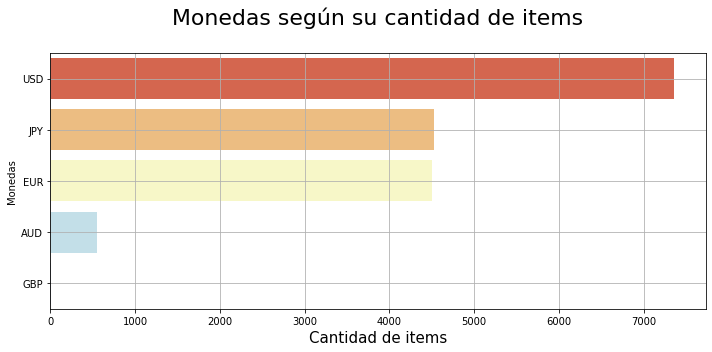

In [20]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_currency_show,x='Count',y='Total_Amount_Currency',palette="RdYlBu")
plt.grid(True)
plt.xlabel('Cantidad de items',size=15)
plt.ylabel('Monedas')
plt.title('Monedas según su cantidad de items\n',size=22)
plt.tight_layout()
plt.savefig("pngs/Items-moneda.png")

In [21]:
df_item_amount_aux = df_item_amount.loc[:,["ID","Product_Name","Stage","Total Item Amount (USD)"]]
df_item_amount_show_loss = df_item_amount_aux[df_item_amount_aux["Stage"] == "Closed Lost"].nlargest(10,"Total Item Amount (USD)")
df_item_amount_show_won = df_item_amount_aux[df_item_amount_aux["Stage"] == "Closed Won"].nlargest(10,"Total Item Amount (USD)")
df_final_show = df_item_amount_show_won.append(df_item_amount_show_loss).sort_values("Total Item Amount (USD)",ascending=False)
df_final_show

,ID,Product_Name,Stage,Total Item Amount (USD)
16682,21007,Product_Name_307,Closed Lost,3.150001e+08
16616,28458,Product_Name_307,Closed Lost,2.562015e+08
2179,10808,Product_Name_110,Closed Lost,2.445877e+08
7364,14461,Product_Name_411,Closed Lost,1.587382e+08
3667,8037,Product_Name_98,Closed Lost,1.539788e+08
2806,4909,Product_Name_32,Closed Lost,1.237501e+08
16317,19642,Product_Name_307,Closed Lost,1.023999e+08
16409,23987,Product_Name_307,Closed Lost,9.600192e+07
16408,23984,Product_Name_307,Closed Lost,9.600192e+07
2298,18169,Product_Name_307,Closed Lost,9.449991e+07


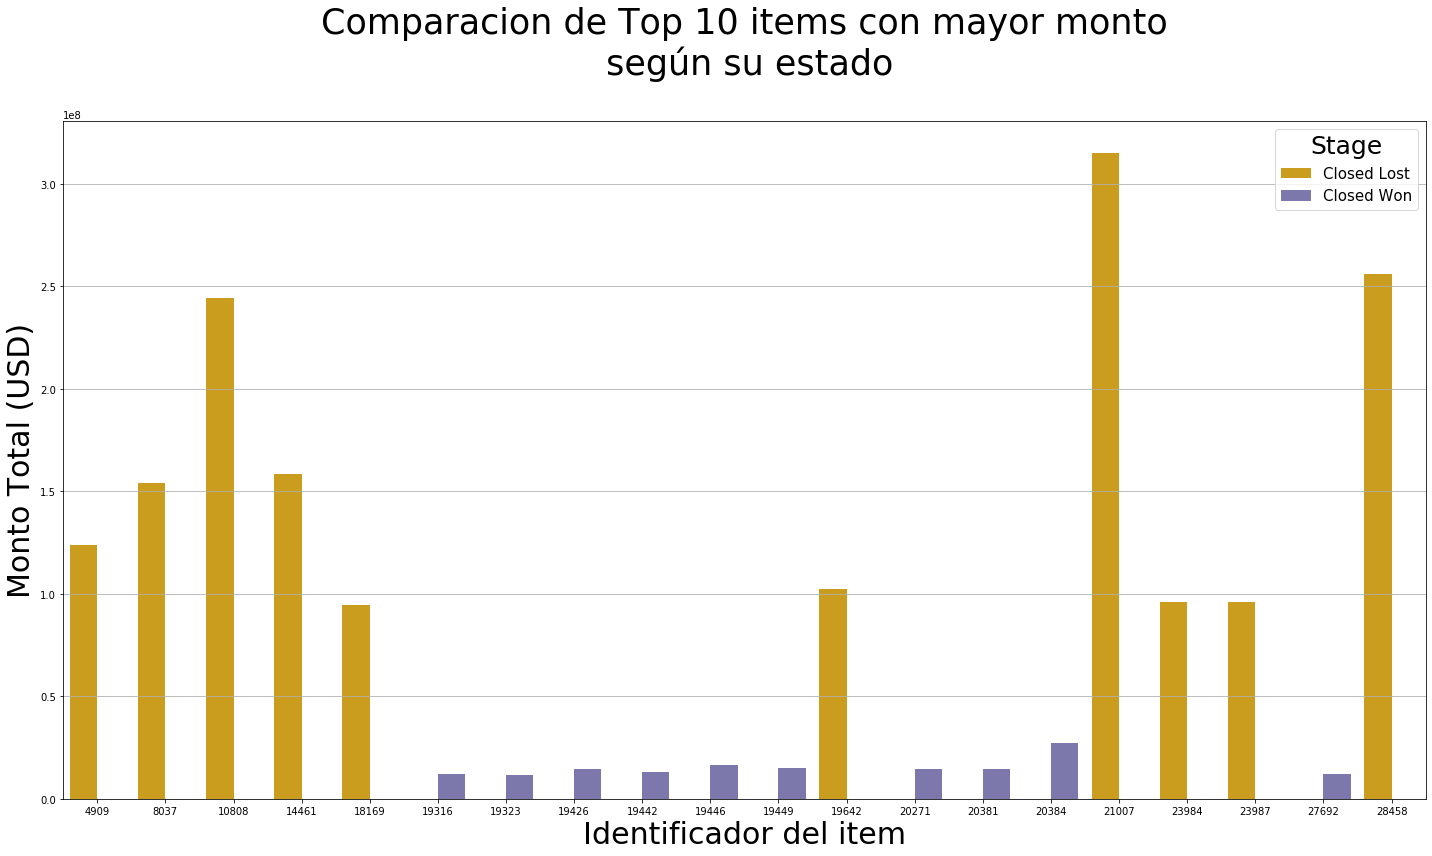

In [22]:
fig,ax=plt.subplots(figsize=(20,12))
plt.grid(True)
g = sns.barplot(ax=ax,data=df_final_show,x='ID',y='Total Item Amount (USD)',palette='Dark2_r',hue='Stage')
g.set_title('Comparacion de Top 10 items con mayor monto\n según su estado\n',size=35)
g.set_xlabel('Identificador del item',size=30)
g.set_ylabel('Monto Total (USD)',size=30)
g.legend(title='Stage',fontsize = '15',title_fontsize='25',loc='upper right')
plt.tight_layout()
plt.savefig("pngs/Items-comparacion-top-ten.png")

In [23]:
df_product_amount_show = df_item_amount[df_item_amount["Total Item Amount (USD)"].isnull() != True].groupby("Product_Name")\
.agg({"Total Item Amount (USD)":["max","mean"]}).reset_index()
df_product_amount_show.columns = ["Product_Name","Monto Total Maximo","Monto Total Promedio"]
df_product_amount_max_show = df_product_amount_show.nlargest(10,"Monto Total Maximo")
df_product_amount_mean_show = df_product_amount_show.nlargest(10,"Monto Total Promedio")
df_product_amount_max_show

,Product_Name,Monto Total Maximo,Monto Total Promedio
180,Product_Name_307,3.150001e+08,2.961773e+07
10,Product_Name_110,2.445877e+08,4.943363e+06
282,Product_Name_411,1.587382e+08,1.763021e+07
419,Product_Name_98,1.539788e+08,1.556375e+07
191,Product_Name_32,1.237501e+08,4.210010e+07
317,Product_Name_445,9.247493e+07,1.433388e+07
164,Product_Name_286,8.843700e+07,1.791412e+07
304,Product_Name_432,8.665998e+07,1.513719e+07
197,Product_Name_325,6.300000e+07,1.761659e+07
205,Product_Name_339,6.299982e+07,1.814660e+07


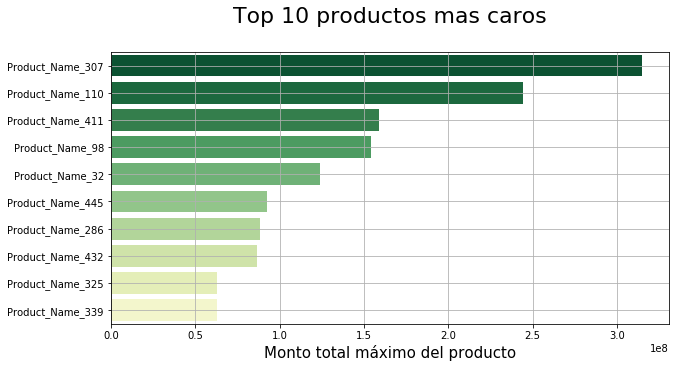

In [24]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_product_amount_max_show,x='Monto Total Maximo',y='Product_Name',palette="YlGn_r")
plt.grid(True)
plt.xlabel('Monto total máximo del producto',size=15)
plt.ylabel('')
plt.title('Top 10 productos mas caros\n',size=22)
plt.savefig("pngs/Producto-top-ten-max.png")

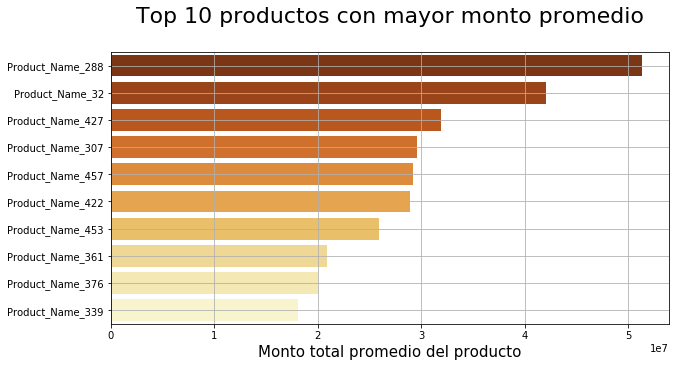

In [25]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_product_amount_mean_show,x='Monto Total Promedio',y='Product_Name',palette="YlOrBr_r")
plt.grid(True)
plt.xlabel('Monto total promedio del producto',size=15)
plt.ylabel('')
plt.title('Top 10 productos con mayor monto promedio\n',size=22)
plt.savefig("pngs/Producto-top-ten-mean.png")

In [26]:
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,convertion,Total Item Amount (USD)
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None,1.131096,5964043.80
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None,1.131094,54552.68
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000,83865.60
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None,1.000000,7421881.50
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000,13357192.50


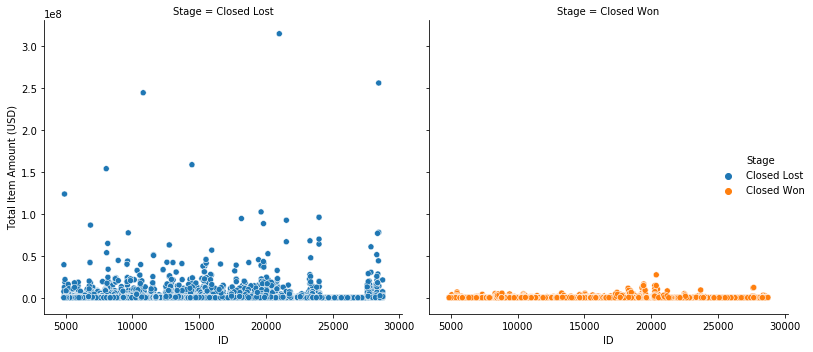

In [27]:
df_item_amount_scatter_1 = df_item_amount.loc[df_item_amount["Stage"].isin(['Closed Won','Closed Lost']),:]

sns.relplot(data=df_item_amount_scatter_1, x='ID', y='Total Item Amount (USD)',hue='Stage',col="Stage",kind="scatter")
plt.tight_layout()
plt.savefig("pngs/Items-montos.png")

In [28]:
df_stage_complete = df.groupby('Opportunity_Name').agg({'Stage': 'last'}).reset_index()
df_stage_complete = df_stage_complete['Stage'].value_counts().to_frame().reset_index()
df_stage_complete["Total"] = df_stage_complete["Stage"].sum()
df_stage_complete["Count/Total"] = df_stage_complete["Stage"] / df_stage_complete["Total"]
df_stage_complete["Percentage"] = df_stage_complete["Count/Total"] * 100
df_stage_complete.columns = ["Stage","Count","Total","Count/Total","Percentage"]
df_stage_complete

,Stage,Count,Total,Count/Total,Percentage
0,Closed Won,5072,9841,0.515395,51.539478
1,Closed Lost,4719,9841,0.479524,47.952444
2,Proposal,30,9841,0.003048,0.304847
3,Negotiation,11,9841,0.001118,0.111777
4,Qualification,9,9841,0.000915,0.091454


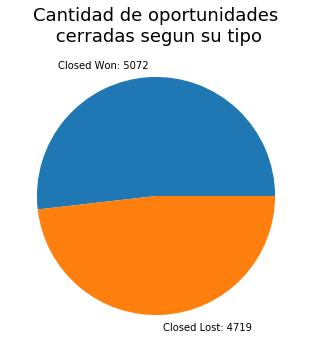

In [29]:
df_stage_closed = df_stage_complete[df_stage_complete["Stage"].str.contains("Closed")].round(2)

fig1,ax1 = plt.subplots(figsize=(5,5))
labels_closed=df_stage_closed['Stage']+": " + (df_stage_closed['Count']).astype(str)
explode_closed = (0, 0)
colors = [] #podemos cambiar los colores
ax1.pie(df_stage_closed['Count'],labels=labels_closed,explode=explode_closed)
plt.title('Cantidad de oportunidades\n cerradas segun su tipo',size=18)
plt.tight_layout()
plt.savefig("pngs/Oportunidades-closed-cantidad.png")
plt.show()

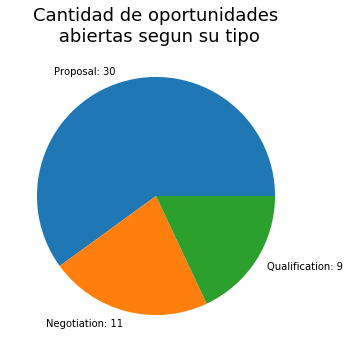

In [30]:
df_stage_open = df_stage_complete[df_stage_complete["Stage"].str.contains("Closed") != True].round(2)

fig2,ax2 = plt.subplots(figsize=(5,5))
labels_open=df_stage_open['Stage']+": " + (df_stage_open['Count']).astype(str)
explode_open = (0, 0, 0)
ax2.pie(df_stage_open['Count'],labels=labels_open,explode=explode_open)
plt.title('Cantidad de oportunidades\n abiertas segun su tipo',size=18)
plt.tight_layout()
plt.savefig("pngs/Oportunidades-open-cantidad.png")
plt.show()

In [31]:
df_item_amount_closed = df_item_amount.loc[df_item_amount["Stage"].str.contains("Closed"),["ID","Stage","Product_Name","Total Item Amount (USD)"]]
df_item_amount_closed = df_item_amount_closed.dropna().sort_values("Total Item Amount (USD)")
df_item_amount_closed = df_item_amount_closed.groupby(["Total Item Amount (USD)","Stage"]).agg({"ID":"count"}).unstack()
df_item_amount_closed.columns = ["Closed Lost Count","Closed Won Count"]
df_item_amount_closed = (df_item_amount_closed.divide(df_item_amount_closed.sum(axis=1), axis=0) * 100).fillna(0)
df_item_amount_closed

,Closed Lost Count,Closed Won Count
Total Item Amount (USD),,
0.000000e+00,93.939394,6.060606
1.000000e-02,14.285714,85.714286
2.000000e-02,100.000000,0.000000
4.000000e-02,100.000000,0.000000
1.000000e-01,100.000000,0.000000
...,...,...
1.539788e+08,100.000000,0.000000
1.587382e+08,100.000000,0.000000
2.445877e+08,100.000000,0.000000


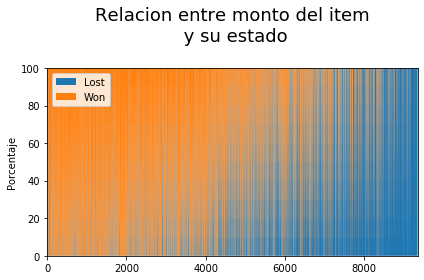

In [32]:
rows = len(df_item_amount_closed.index + 1)
plt.stackplot(range(0,rows),  df_item_amount_closed["Closed Lost Count"],  df_item_amount_closed["Closed Won Count"], labels=['Lost','Won'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Relacion entre monto del item\n y su estado\n',size=18)
plt.ylabel('Porcentaje')
plt.tight_layout()
plt.savefig("pngs/Relacion-estado-item-monto.png")
plt.show()

In [66]:
df_product_amount = df_item_amount.loc[df_item_amount["Stage"].str.contains("Closed"),["ID","Stage","Product_Name","Product_Family","Total Item Amount (USD)"]]
df_product_amount_show = df_product_amount.groupby(["Product_Name","Product_Family"]).agg({"Total Item Amount (USD)":["mean","max","min","count"]}).dropna().reset_index()
df_product_amount_show

Product_Name     Product_Family Total Item Amount (USD)  \
                                                            mean   
0    Product_Name_100  Product_Family_77            6.682535e+04   
1    Product_Name_101  Product_Family_83            1.251900e+04   
2    Product_Name_102  Product_Family_84            4.128429e+03   
3    Product_Name_103  Product_Family_82            1.920161e+04   
4    Product_Name_104  Product_Family_86            5.327605e+03   
..                ...                ...                     ...   
406   Product_Name_95  Product_Family_80            3.901365e+04   
407   Product_Name_96  Product_Family_77            4.399920e+05   
408   Product_Name_97  Product_Family_77            1.067773e+06   
409   Product_Name_98  Product_Family_77            1.556375e+07   
410   Product_Name_99  Product_Family_77            2.737123e+06   

                                     
              max         min count  
0    1.219400e+07        0.00   963  
1    2.873000e+04      546.00     4  
2    1.878500e+04      132.60    14  
3    3.805459e+04     1852.50     8  
4    2.650000e+04       39.75     6  
..            ...         ...   ...  
406  4.001400e+04    38013.30     2  
407  8.670999e+05   181588.68   135  
408  1.552762e+06        0.00    47  
409  1.539788e+08  5762640.00    41  
410  5.964044e+06   929994.00   123  

[411 rows x 6 columns]

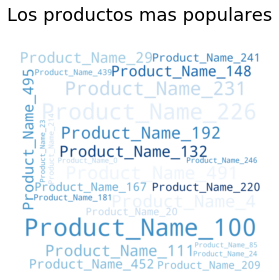

In [64]:
wc= WordCloud(background_color="white",collocations=False, width=3000, height=2800, max_words=25,colormap="Blues")
wordcloud = wc.generate(' '.join(df['Product_Name']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Los productos mas populares\n',size=18)
plt.margins(0,0)
plt.tight_layout()
plt.savefig("pngs/item-populares.png")
plt.show()

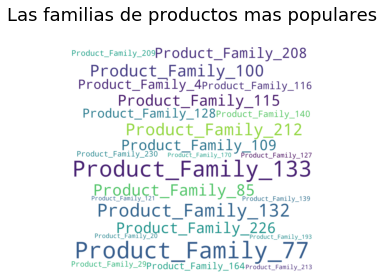

In [63]:
wc= WordCloud(background_color="white",collocations=False, width=3000, height=2800, max_words=25)
wordcloud = wc.generate(' '.join(df['Product_Family']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Las familias de productos mas populares\n',size=18)
plt.margins(0,0)
plt.tight_layout()
plt.savefig("pngs/item-familia-populares.png")
plt.show()


In [111]:
df_family_product = df.loc[:,["ID","Product_Family","Product_Name"]].groupby(["Product_Family","Product_Name"]).agg({"ID":"count"}).reset_index()
df_family_product_ten = df_family_product.nlargest(10,"ID")
df_family_product_pivot = df_family_product_ten.pivot("Product_Family", "Product_Name", "ID").fillna(0)
df_family_product_pivot

Product_Name,Product_Name_100,Product_Name_111,Product_Name_132,Product_Name_192,Product_Name_226,Product_Name_231,Product_Name_29,Product_Name_4,Product_Name_491,Product_Name_495
Product_Family,,,,,,,,,,
Product_Family_100,0.0,0.0,383.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Product_Family_115,0.0,0.0,0.0,442.0,0.0,0.0,0.0,0.0,0.0,0.0
Product_Family_132,0.0,0.0,0.0,0.0,0.0,579.0,0.0,0.0,0.0,0.0
Product_Family_133,0.0,0.0,0.0,0.0,836.0,0.0,0.0,0.0,0.0,0.0
Product_Family_226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,524.0,0.0
Product_Family_230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0
Product_Family_29,0.0,0.0,0.0,0.0,0.0,0.0,345.0,0.0,0.0,0.0
Product_Family_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474.0,0.0,0.0
Product_Family_77,976.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


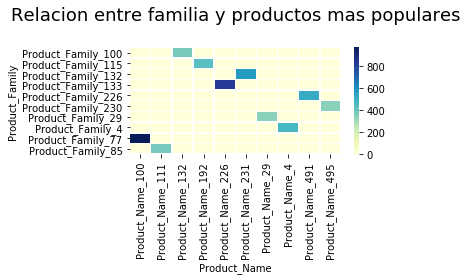

In [112]:
sns.heatmap(df_family_product_pivot,cmap="YlGnBu",linewidths=.5)
plt.title('Relacion entre familia y productos mas populares\n',size=18)
plt.margins(0,0)
plt.tight_layout()
plt.savefig("pngs/item-familia-populares.png")
plt.show()

Text(0.5, 1.0, 'Relaciones de productos con su familia')

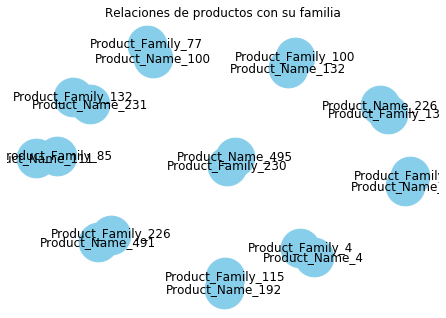

In [124]:
# Build your graph
G=nx.from_pandas_edgelist(df_family_product_ten, 'Product_Name', 'Product_Family')
nx.draw(G, with_labels=True, node_size=1500, node_color="skyblue", pos=nx.spring_layout(G), width=2)
plt.title("Relaciones de productos con su familia")